# **PUNTO 1**
Análisis de variables de entrada y visualización categorías vs ratings

Importación de librerías y lectura de ficheros

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import seaborn as sns


data = pd.read_json("full_format_recipes.json")

A continuación se selección las 15 categorías más importantes y se agrupan en una misma lista

In [46]:
categories_counts = data['categories'].explode().value_counts().head(15)
selected_categories = categories_counts.index
print(selected_categories)

Index(['Bon Appétit', 'Peanut Free', 'Soy Free', 'Tree Nut Free', 'Vegetarian',
       'Gourmet', 'Kosher', 'Pescatarian', 'Quick & Easy', 'Wheat/Gluten-Free',
       'Bake', 'Summer', 'Dessert', 'Dairy Free', 'Side'],
      dtype='object', name='categories')


Validación de información

In [47]:
# Validación de filas
data['has_category'] = data['categories'].apply(
   lambda x: [cat for cat in x if cat in selected_categories] if isinstance(x, list) else []
)

data_exploded = data.explode('has_category')
data_exploded = data_exploded.dropna(subset=['has_category'])

#Validación que no haya ratings nulos
data_exploded = data_exploded.dropna(subset=['rating'])

A continuación se hace la media de la valoración de cada categoría. Es decir, se hace una media de la valoración entre todas las recetas que tiene la categoría.
Creamos una lista con las 15 principales categorías y la media de sus ratings ordenados en orden descendiente.

In [48]:
category_mean_ratings = data_exploded.groupby('has_category')['rating'].mean().sort_values(ascending=False)
print(category_mean_ratings)

has_category
Bake                 3.908764
Bon Appétit          3.893038
Peanut Free          3.866359
Soy Free             3.866067
Tree Nut Free        3.862685
Kosher               3.833198
Pescatarian          3.824789
Quick & Easy         3.814687
Gourmet              3.804622
Side                 3.794430
Dessert              3.789882
Summer               3.787642
Wheat/Gluten-Free    3.785798
Vegetarian           3.776110
Dairy Free           3.773004
Name: rating, dtype: float64


Para visualizar estos valores se realiza un historgrama.

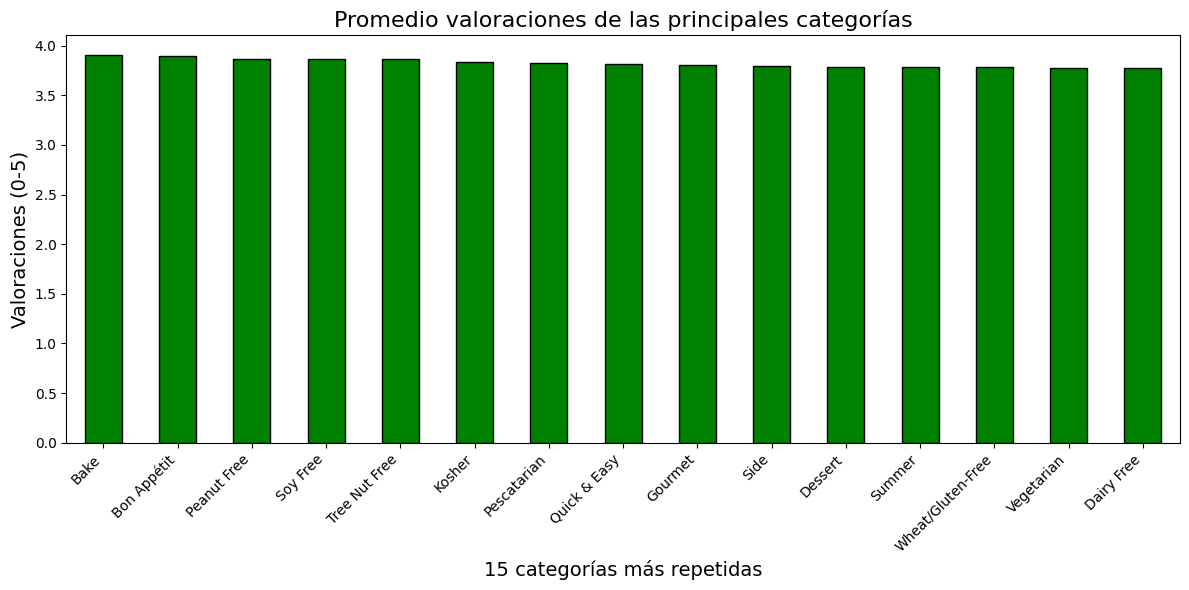

In [49]:
plt.figure(figsize=(12,6))
category_mean_ratings.plot(kind='bar', color='green', edgecolor='black')
plt.title("Promedio valoraciones de las principales categorías", fontsize=16)
plt.xlabel("15 categorías más repetidas", fontsize=14)
plt.ylabel("Valoraciones (0-5)", fontsize=14)
plt.xticks(rotation=45, fontsize=10, ha="right")
plt.tight_layout()
plt.show()

Al analizar las categorías, también puede ser importante recalcar las categorías mejores valoradas y su frecuencia de uso.

Generamos una lista con todas las categorías

In [50]:
data['categories'] = data['categories'].apply(lambda x: x if isinstance(x, list) else [])
data_exploded = data.explode('categories')

Se elimina nuevamente filas con categorías o valoraciones nulas

In [51]:
data_exploded = data_exploded.dropna(subset=['categories', 'rating'])

Cálculo del promedio de todas las categorías y selección de las 5 más valoradas. Finalmente, se calcula la frecuencia de estas categorías.

In [52]:
category_mean_ratings = data_exploded.groupby('categories')['rating'].mean()
top_5_categories = category_mean_ratings.nlargest(5).index
category_counts = data_exploded['categories'].value_counts()
top_5_counts = category_counts.loc[top_5_categories]

Para este caso, se usa un piechart para representar los datos.

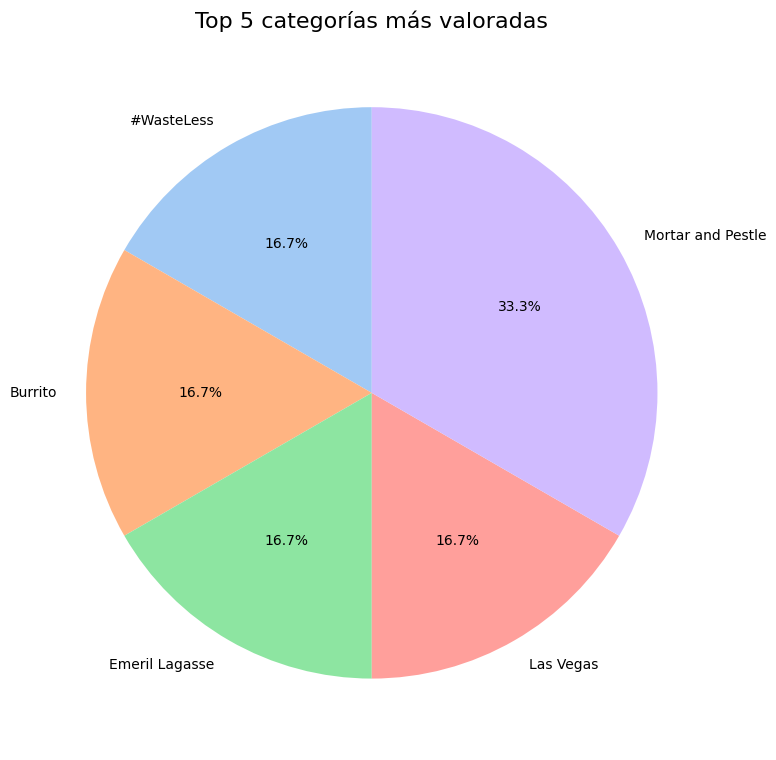

Frecuencia de las 5 categorías más valoradas:
categories
#WasteLess           1
Burrito              1
Emeril Lagasse       1
Las Vegas            1
Mortar and Pestle    2
Name: count, dtype: int64


In [53]:
plt.figure(figsize=(8, 8))
top_5_counts.plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel"),
    ylabel='',
    labels=top_5_counts.index
)
plt.title("Top 5 categorías más valoradas", fontsize=16)
plt.tight_layout()
plt.show()
print("Frecuencia de las 5 categorías más valoradas:")
print(top_5_counts)

Punto 2 Implementación de un pipeline para el preprocesado de los textos. Para esta tarea puede usar las librerías habituales (NLTK, Gensim o SpaCy), o cualquier otra librería que considere oportuna.

Importación librerias

In [54]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

Extracción variable descripciones y eliminación de las filas que no hay descripciones

In [55]:
data = pd.read_json("full_format_recipes.json")
desc_col = data['desc'].fillna("")
descriptions = []
for desc in data['desc']:
    if isinstance(desc, str) and desc.strip() != "":
        descriptions.append(desc)

data = data[data['desc'].isin(descriptions)]

Descarga de recursos ntlk

In [56]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re
import nltk

def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

try:
  import lxml
except ModuleNotFoundError:
  %pip install lxml

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Se eliminan carácteres especiales y números de la descripción. En resumen, se elimina todo aquello que no son palabras.

In [57]:
def eliminar_car(text):
    if pd.isnull(text):  # Manejar valores nulos
        return ""
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\d+", "", text)
    return text

# Aplicar wrangle_text a la columna 'desc'
data['cleaned_desc'] = data['desc'].apply(eliminar_car)
eliminar_car_desc=data['cleaned_desc']

Realizamos un print del resultado de aplicar esta primera parte del preprocesamiento

In [58]:
from termcolor import colored
print(colored('\n============= Original Description =============', 'blue'))
print(data['desc'].iloc[0])

print(colored('\n============= After Wrangling Result =============', 'blue'))
print(data['cleaned_desc'].iloc[0])


============= Original Description =============
This uses the same ingredients found in boudin blanc, the classic French white sausage. Start two days before serving.

============= After Wrangling Result =============
This uses the same ingredients found in boudin blanc the classic French white sausage Start two days before serving


Tokenización
Tokenizaremos en frases y en palabras, aunque para el desarrollo del proyecto usamos tokenización en las palabras.

In [59]:
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize

nltk.download('punkt_tab')
desc_tokens = eliminar_car_desc.apply(wordpunct_tokenize)
desc_tokens_sent = eliminar_car_desc.apply(lambda text: [wordpunct_tokenize(sent) for sent in sent_tokenize(text)])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Comparamos el primer documento después del wrangle vs después de tokenizar

In [60]:
print(colored('\n============= After Wrangling Result =============', 'blue'))
print(data['cleaned_desc'].iloc[0])
print(colored('\n============= After Tokenizing by words) =============', 'blue'))
print(desc_tokens.iloc[0])
print(colored('\n============= Sentences tokeneized =============', 'blue'))
print(desc_tokens_sent.iloc[0])


============= After Wrangling Result =============
This uses the same ingredients found in boudin blanc the classic French white sausage Start two days before serving

============= After Tokenizing by words) =============
['This', 'uses', 'the', 'same', 'ingredients', 'found', 'in', 'boudin', 'blanc', 'the', 'classic', 'French', 'white', 'sausage', 'Start', 'two', 'days', 'before', 'serving']

============= Sentences tokeneized =============
[['This', 'uses', 'the', 'same', 'ingredients', 'found', 'in', 'boudin', 'blanc', 'the', 'classic', 'French', 'white', 'sausage', 'Start', 'two', 'days', 'before', 'serving']]


Una vez tenemos tokenizadas las descripciones procedemos con la Homogenización que consistira en tres partes.

La primera parte será convertir a minusculas los tokens

In [61]:
def lowercase_tokens(tokens):
    return [token.lower() for token in tokens]
tokens_minusc=desc_tokens.apply(lowercase_tokens)

Visualizamos el resultado

In [62]:
print(tokens_minusc.iloc[0])

['this', 'uses', 'the', 'same', 'ingredients', 'found', 'in', 'boudin', 'blanc', 'the', 'classic', 'french', 'white', 'sausage', 'start', 'two', 'days', 'before', 'serving']


Aplicamos Lemmatizer. Nos permite normalizar los tokens.

In [63]:
from nltk.stem import WordNetLemmatizer

wnl = WordNetLemmatizer()
lemmatized_desc = tokens_minusc.apply(
    lambda tokens: [wnl.lemmatize(token) for token in tokens]
)

Visualizamos el primer documento

In [64]:
print(colored('\n============= Lemmatized review  =============', 'blue'))
print(lemmatized_desc.iloc[0])


============= Lemmatized review  =============
['this', 'us', 'the', 'same', 'ingredient', 'found', 'in', 'boudin', 'blanc', 'the', 'classic', 'french', 'white', 'sausage', 'start', 'two', 'day', 'before', 'serving']


Finalmente, realizamos el cleaning donde aplicamos stopwrods. Seleccionamos 'english' ya que es el idioma del fichero.

In [65]:
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')

stopwords_en = set(stopwords.words("english"))
clean_desc = [[token for token in tokens if token not in stopwords_en] for tokens in lemmatized_desc]


Visualizamos la limpieza final en el primer documento.

In [66]:
print(colored('\n============= Lemmatized review  =============', 'blue'))
print(lemmatized_desc.iloc[0])
print(colored('\n============= Clean lemmatized review  =============', 'blue'))
print(clean_desc)


============= Lemmatized review  =============
['this', 'us', 'the', 'same', 'ingredient', 'found', 'in', 'boudin', 'blanc', 'the', 'classic', 'french', 'white', 'sausage', 'start', 'two', 'day', 'before', 'serving']

============= Clean lemmatized review  =============
[['us', 'ingredient', 'found', 'boudin', 'blanc', 'classic', 'french', 'white', 'sausage', 'start', 'two', 'day', 'serving'], ['sicilianstyle', 'tomato', 'sauce', 'ha', 'ton', 'mediterranean', 'flavor', 'thanks', 'orange', 'peel', 'olive', 'oregano'], ['recipe', 'prepared', 'minute', 'less'], ['serve', 'newfangled', 'maincourse', 'salad', 'crisp', 'flatbread', 'lavash', 'white', 'wine', 'rosé', 'spritzer'], ['pop', 'one', 'mouth', 'burst', 'bittersweet', 'flavor'], ['bulgogi'], ['transform', 'picnic', 'un', 'piquenique', 'remember', 'elegant', 'arrangement', 'tangy', 'potato', 'salad', 'pea', 'gently', 'mashed', 'marjoram', 'salty', 'ham', 'softly', 'set', 'parsleyed', 'gelatin'], ['simmering', 'yam', 'fill', 'flavor',

# **PUNTO 3**
Representación vectorial de los documentos mediante tres procedimientos diferentes: TF-IDF, Word2Vec,Embeddings

Primero de todo debemos crear un diccionario con el resultado final del preprocesamiento

In [67]:
from gensim.corpora import Dictionary

mycorpus = clean_desc
D = Dictionary(mycorpus)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 17842 terms
First terms in the dictionary:
0 : blanc
1 : boudin
2 : classic
3 : day
4 : found
5 : french
6 : ingredient
7 : sausage
8 : serving
9 : start


Una vez definido el diccionario, pasaremos al filtraje de ttérminos poco o muy comunes de este.


*   Se conservarán las palabras que aparezcan en al menos 5 documentos del corpus.
*   Se eliminarán las palabras que aparezcan en más del 75% de los documentos del corpus.



In [68]:
no_below = 5
no_above = .75

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

print('The dictionary contains', n_tokens, 'terms')

print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The dictionary contains 4449 terms
First terms in the dictionary:
0 : blanc
1 : classic
2 : day
3 : found
4 : french
5 : ingredient
6 : sausage
7 : serving
8 : start
9 : two


Ahora podremos visualizar el número de veces que sale cada token con el metodo BOW

In [69]:
mycorpus_bow = [D.doc2bow(doc) for doc in mycorpus]
mycorpus_bow_flat = [item for sublist in mycorpus_bow for item in sublist]
print("Representación BoW del primer documento:")
print(mycorpus_bow[0])

Representación BoW del primer documento:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1)]


TF-IDF


In [70]:
from gensim.models import TfidfModel

tfidf = TfidfModel(mycorpus_bow)

tfidf_corpus = []
for doc in mycorpus_bow:
  tfidf_vector_tuple = tfidf[doc]
  tfidf_vector = []
  for vector in tfidf_vector_tuple:
    tfidf_vector.append(vector[1])
  tfidf_corpus.append(tfidf_vector)

In [71]:
from gensim.models import TfidfModel
from gensim.matutils import corpus2dense

# Entrenar el modelo TF-IDF
tfidf = TfidfModel(mycorpus_bow)

# Convertir el corpus TF-IDF a una matriz densa
tfidf_dense = corpus2dense(tfidf[mycorpus_bow], num_terms=len(D)).T
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Calcular TF-IDF
tfidf_corpus = [[vector[1] for vector in tfidf[doc]] for doc in mycorpus_bow]

# Asegurar dimensiones uniformes rellenando con ceros
max_length = max(len(doc) for doc in tfidf_corpus)
tfidf_corpus_padded = pad_sequences(tfidf_corpus, maxlen=max_length, padding='post', dtype='float32')
print("Primer documento original:", clean_desc[0])
print("Representación TF-IDF del primer documento:", tfidf_dense[0])

Primer documento original: ['us', 'ingredient', 'found', 'boudin', 'blanc', 'classic', 'french', 'white', 'sausage', 'start', 'two', 'day', 'serving']
Representación TF-IDF del primer documento: [0.4089822  0.22135127 0.21783043 ... 0.         0.         0.        ]


Vemos el resultado, comparando el primero documento preprocesado vs con el TFIDF

In [72]:
print("Representación del primer documento preprocesado:")
print(clean_desc[0])
print("Representación de TFIDF del primer documento:")
print(tfidf_corpus[0])

Representación del primer documento preprocesado:
['us', 'ingredient', 'found', 'boudin', 'blanc', 'classic', 'french', 'white', 'sausage', 'start', 'two', 'day', 'serving']
Representación de TFIDF del primer documento:
[0.40898218334897296, 0.22135126622397988, 0.21783043492959261, 0.3099728126644617, 0.2895441930031849, 0.2546828975124987, 0.31937664380803693, 0.2746358912869206, 0.24229156832955084, 0.25637023031361866, 0.3462037774725044, 0.2641788441193919]


Word2Vec

In [73]:
from gensim.models import Word2Vec
import numpy as np
# Entrenamiento modelo Word2Vec
word2vec_model = Word2Vec(sentences=mycorpus, vector_size=100, window=5, min_count=1, workers=4)

# Obtenemos la representación de un documento como promedio de sus vectores de palabras
document_vectors = []
for doc in mycorpus:
    vectors = [word2vec_model.wv[word] for word in doc if word in word2vec_model.wv]
    if vectors:
        avg_vector = np.mean(vectors, axis=0)
        document_vectors.append(avg_vector)
    else:
        document_vectors.append(np.zeros(word2vec_model.vector_size))
document_vectors = np.array(document_vectors)

Primer documento con Word2Vec

In [74]:
print("Representación de Word2Vec del primer documento:")
print(document_vectors[0])

Representación de Word2Vec del primer documento:
[-0.38283703  0.7654077   0.0536356  -0.22665599  0.2982917  -1.072954
  0.22245772  1.4474837  -0.22239922 -0.4809292  -0.32619455 -1.3703997
 -0.24979486  0.27944532  0.26451534 -0.46044534  0.05092815 -0.83708924
  0.06372468 -0.87939113  0.42554107  0.19216093  0.1231451  -0.3796701
 -0.31469977 -0.04869904 -0.4363897  -0.41963848 -0.5392106  -0.20012137
  0.5929662   0.19831623 -0.06191396 -0.29176074 -0.23729135  0.5880355
  0.37359402 -0.19860077 -0.0116449  -1.1192359   0.04782171 -0.76893944
 -0.26240835 -0.12019365  0.32931775 -0.06069372 -0.5169056   0.24521859
  0.19238843  0.36259848  0.18250005 -0.49793327 -0.14863268  0.00666586
 -0.49636877  0.5437512   0.5207066   0.3623174  -0.50728095  0.28087652
  0.0834123   0.23551321 -0.35122263 -0.20578793 -0.6740859   0.4310992
  0.09954321  0.26467174 -0.61930716  0.7724142  -0.2635519   0.35486418
  0.76185644 -0.3914389   0.60759443  0.35861686 -0.03935037 -0.23291564
 -0.5457

Embeddings contextuales - BERT

Cargar del modelo y el tokenizador de BERT

In [75]:
import torch
from transformers import BertTokenizer, BertModel

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Procesar cada documento en el corpus y generar su representación utilizando el modelo BERT

In [76]:
bert = []
for n, doc in enumerate(mycorpus):
    print(f'\rBert #{n + 1} out of {len(mycorpus)}', end='', flush=True)

    # Se añaden tokens especiales
    marked_text = "[CLS] " + ' '.join(doc) + " [SEP]"

    # Comversión de la frase a tokens
    tokenized_text = tokenizer.tokenize(marked_text)
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    # Todos los tokens se asignan al pprimer segmento ya que solo se procesa una frase
    segments_ids = [1] * len(tokenized_text)

    # Crear tensores de tokens y segmentos
    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    # Generación embeddings con BERT
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)

    # Obtenemos los hidden states (última capa)
    hidden_states = outputs.hidden_states

    # Queremos un vector por frase, así que hacemos la media de los vectores
    token_vecs = hidden_states[-2][0]  # Penúltima capa, tokens de la frase
    sentence_embedding = torch.mean(token_vecs, dim=0)  # Promedio para obtener el embedding de la frase

    # Guardamos el embedding
    bert.append(sentence_embedding)

# Mostramos el vector del primer documento
print("Representación de Bert del primer documento:")
print(bert[0])

Bert #1 out of 13495

KeyboardInterrupt: 

Representación de la distribución de los documentos

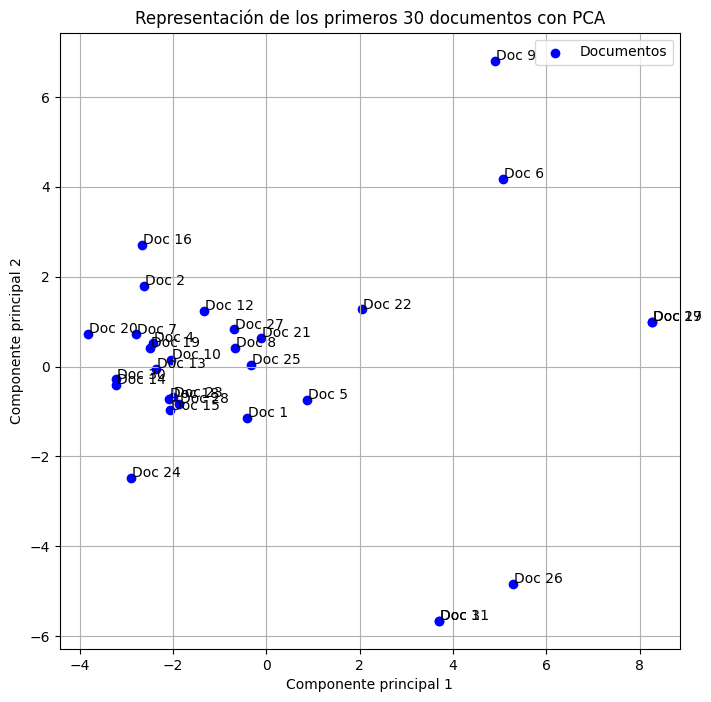

In [37]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt

# Asegúrate de que 'bert' contiene al menos 30 embeddings de documentos
# Seleccionamos los primeros 30 documentos para visualización
embeddings = np.array([doc.cpu().numpy() for doc in bert[:30]])  # Solo los primeros 30 embeddings

# Aplicar PCA para reducir la dimensión de cada embedding a 2 componentes
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings)

# Visualizar
plt.figure(figsize=(8, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], color='blue', label='Documentos')
for i, txt in enumerate(range(30)):
    plt.text(reduced_embeddings[i, 0] + 0.02, reduced_embeddings[i, 1] + 0.02, f'Doc {i+1}', fontsize=10)
plt.title("Representación de los primeros 30 documentos con PCA")
plt.xlabel("Componente principal 1")
plt.ylabel("Componente principal 2")
plt.legend()
plt.grid(True)
plt.show()




# **PUNTO 4**
Entrenamiento y evaluación mediante redes neuronales y KNN

Redes Neuronales utilizando PyTorch

Carga de datos de la variable rating (Y) y almacenamiento de la variable X (puede ser el vector Word2Vec, tfidf corpus y el resultadod de la BERT)

In [77]:
from sklearn.model_selection import train_test_split

X = document_vectors
X_2 = tfidf_corpus_padded
X_3 = np.array(bert)
y = data['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Convertir a tensores. Para la variable Y habían NANs, se ha puesto un 0 dónde había NAN. Se ha usado print("NaN en X:", np.isnan(y_test_tensor).any())
print("Inf en X:", np.isinf(y_test_tensor).any()) para ver si los tensores tenian NAN.

In [78]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)


A continuación se muestra como se ha resuelto las NANS en Y

In [79]:
mean_value_train = np.nanmean(y_train)  # Calcula la media de y_train con NumPy
mean_value_test = np.nanmean(y_test)  # Calcula la media de y_test con NumPy

# Reemplazar NaN en y_train y y_test
y_train = np.nan_to_num(y_train, nan=mean_value_train)
y_test = np.nan_to_num(y_test, nan=mean_value_test)

# Convertir y_train e y_test a tensores de tipo float32
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

Creación red neuronal de regresión

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim

class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Salida de regresión

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Creación instáncia

In [81]:
input_dim = X_train_tensor.shape[1]
model = RegressionNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Entrenamiento del modelo mediante 50 épocas

In [82]:
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [10/50], Loss: 10.4419
Epoch [20/50], Loss: 3.0205
Epoch [30/50], Loss: 3.2687
Epoch [40/50], Loss: 2.7100
Epoch [50/50], Loss: 2.5273


Evaluación mediante MSE

In [83]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluación
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze()
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()

    # Calcular métricas
    mse = mean_squared_error(y_test_np, y_pred_np)

print(f"PyTorch NN - MSE: {mse:.4f}")

PyTorch NN - MSE: 2.5791


KNN

Conversión de los tensores a arrays

In [84]:
X_train_np = X_train_tensor.cpu().numpy()
X_test_np = X_test_tensor.cpu().numpy()
y_train_np = y_train_tensor.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

Creación y entrenamiento del modelo.
Se puede ajustar n_neighbors

In [85]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score


knn = KNeighborsRegressor(n_neighbors=200)
knn.fit(X_train_np, y_train_np)


y_pred_knn = knn.predict(X_test_np)

mse_knn = mean_squared_error(y_test_np, y_pred_knn)

print(f"K-NN - MSE: {mse_knn:.4f}")

K-NN - MSE: 1.7141


# **Punto 5**
Transformers.
Se ha realizado una adaptación del código transformer del enunciado.

Importación de librerías

In [86]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
import numpy as np

# Filtrar las columnas necesarias para el modelo

text_column = 'desc'
data[text_column] = data[text_column].astype(str).fillna("")
data = data.dropna(subset=[text_column, 'rating'])  # Eliminar filas con valores nulos
data = data.iloc[:100].copy()

Tokenización del texto

In [87]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
def tokenize_function(examples):
    return tokenizer(examples[text_column], truncation=True, padding=True, max_length=128)

División del dataset en entrenamiento y validación

In [88]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data[text_column].tolist(), data['rating'].tolist(), test_size=0.2, random_state=42
)

Creación dataset comaptible con Hugging Face

In [89]:
class RecipeDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

Tokenización de los textos de entrenamiento y valdiación

In [90]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

Creación Objetos Dataset

In [91]:
train_dataset = RecipeDataset(train_encodings, train_labels)
val_dataset = RecipeDataset(val_encodings, val_labels)
model = AutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Configurar entrenamiento

In [92]:
# Configurar el entrenamiento
training_args = TrainingArguments(
    output_dir='./results',          # Directorio de salida
    num_train_epochs=20,             # Número de épocas
    per_device_train_batch_size=16, # Tamaño del batch en entrenamiento
    per_device_eval_batch_size=64,  # Tamaño del batch en evaluación
    warmup_steps=500,               # Pasos de calentamiento
    weight_decay=0.01,              # Decaimiento del peso
    logging_dir='./logs',           # Directorio para logs
    logging_steps=10,               # Frecuencia de logging
    eval_strategy="epoch"           # Evaluar al final de cada época
)

Objeto Trainer

In [93]:
from transformers import DataCollatorWithPadding

# Crear un DataCollator para manejar el padding dinámico
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Crear el objeto Trainer sin el parámetro 'tokenizer'
trainer = Trainer(
    model=model,                     # Modelo a entrenar
    args=training_args,              # Argumentos de entrenamiento
    train_dataset=train_dataset,     # Datos de entrenamiento
    eval_dataset=val_dataset,        # Datos de evaluación
    data_collator=data_collator      # Collator para batches
)


Entrenamiento y evaluación

In [43]:
import os

os.environ["WANDB_MODE"] = "disabled"
import wandb
trainer.train()
eval_results = trainer.evaluate()
print("Resultados de evaluación:", eval_results)

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss
1,No log,16.077709
2,14.893800,15.882895
3,14.893800,15.535700
4,14.395400,14.997594
5,14.395400,14.175160
6,13.201800,12.792418
7,13.201800,11.534040
8,11.068500,11.055355
9,11.068500,10.611235
10,9.868800,9.747421


Resultados de evaluación: {'eval_loss': 2.288404941558838, 'eval_runtime': 10.6448, 'eval_samples_per_second': 1.879, 'eval_steps_per_second': 0.094, 'epoch': 20.0}


MSE

In [44]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Obtener predicciones sobre el conjunto de validación
predictions = trainer.predict(val_dataset)

# Extraer las predicciones (están en formato logits)
preds = predictions.predictions.flatten()
true_labels = np.array(val_labels)

# Calcular el MSE
mse = mean_squared_error(true_labels, preds)

print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 2.2884048431997086


# **Extensión**


In [94]:
grasas = data['fat']
publicacion = data['title']
calorias = data['calories']
sodio = data['sodium']
proteinas = data['protein']
print(proteinas)

1      18.0
3       NaN
5      19.0
6       NaN
7       NaN
       ... 
138     2.0
139     4.0
140    20.0
141     NaN
143     0.0
Name: protein, Length: 100, dtype: float64


Criterios de una receta saludable

In [95]:
criterios = (proteinas >= 0.6 * proteinas.max())

Recetas que cumplen

In [96]:
recetas_filtradas = data[criterios]
recetas_filtradas_claorias_altas=recetas_filtradas.sort_values(by='calories', ascending=False)
recetas_filtradas_sodio_bajo = recetas_filtradas.sort_values(by='fat', ascending=True)
recetas_seleccionadas = recetas_filtradas_sodio_bajo.head(2000)
recetas_con_menos_grasass = recetas_seleccionadas.sort_values(by='sodium', ascending=True)
recetas_con_menos_grasas=recetas_con_menos_grasass.head(100)


Visualización

In [97]:
publicaciones_con_menos_grasas = recetas_con_menos_grasas[['title', 'calories', 'protein', 'sodium', 'fat']]
print(publicaciones_con_menos_grasas)

                                           title  calories  protein  sodium  \
87        Roast Chicken With Sorghum and Squash     1143.0     63.0   311.0   
53  Pancetta Roast Chicken with Walnut Stuffing     1203.0     89.0   583.0   
17                  Crisp Braised Pork Shoulder      890.0     59.0  1027.0   
94    Lamb Shanks Braised with Anise and Orange     1118.0     92.0  1226.0   

     fat  
87  77.0  
53  87.0  
17  68.0  
94  70.0  
